In [11]:
import configparser
import os.path as op

CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
aws_access_key = CP.get('hcp', 'AWS_ACCESS_KEY_ID')
aws_secret_key = CP.get('hcp', 'AWS_SECRET_ACCESS_KEY')

def attach_keys(arr):
    return [(e, aws_access_key, aws_secret_key) for e in arr]

In [12]:
def afq_hcp_retest(args):
    import logging
    import s3fs

    from AFQ.data import fetch_hcp
    import AFQ.api as api
    import AFQ.mask as afm
    
    do_single_shell = True
    do_multi_shell = False

    logging.basicConfig(level=logging.INFO)
    log = logging.getLogger(__name__)
    
    fs = s3fs.S3FileSystem()
    
    subject = args[0]
    aws_access_key = args[1]
    aws_secret_key = args[2]

    _, hcp_1200_bids = fetch_hcp(
        [subject],
        profile_name=False,
        study='HCP_1200',
        aws_access_key_id=aws_access_key,
        aws_secret_access_key=aws_secret_key)

    _, hcp_retest_bids = fetch_hcp(
        [subject],
        profile_name=False,
        study='HCP_Retest',
        aws_access_key_id=aws_access_key,
        aws_secret_access_key=aws_secret_key)

    if do_single_shell:
        single_shell_tracking_params = {"n_seeds": 200000, "random_seeds": True}
        myafq_1200_single_shell = api.AFQ(
            hcp_1200_bids,
            brain_mask=afm.LabelledMaskFile('seg', {'scope':'dmriprep'}, exclusive_labels=[0]),
            min_bval=990,
            max_bval=1010,
            tracking_params=single_shell_tracking_params,
            virtual_frame_buffer=True)
        myafq_1200_single_shell.export_all()
        myafq_1200_single_shell.upload_to_s3(fs, "profile-hcp-west/hcp_reliability/single_shell/hcp_1200_new_dipy")
        del myafq_1200_single_shell
        

        myafq_retest_single_shell = api.AFQ(
            hcp_retest_bids,
            brain_mask=afm.LabelledMaskFile('seg', {'scope':'dmriprep'}, exclusive_labels=[0]),
            min_bval=990,
            max_bval=1010,
            tracking_params=single_shell_tracking_params,
            virtual_frame_buffer=True)
        myafq_retest_single_shell.export_all()
        myafq_retest_single_shell.upload_to_s3(fs, "profile-hcp-west/hcp_reliability/single_shell/hcp_retest_new_dipy")
        del myafq_retest_single_shell

    if do_multi_shell:
        multi_shell_tracking_params = {"odf_model": "DKI", "n_seeds": 200000, "random_seeds": True}
        myafq_1200_multi_shell = api.AFQ(
            hcp_1200_bids,
            brain_mask=afm.LabelledMaskFile('seg', {'scope':'dmriprep'}, exclusive_labels=[0]),
            tracking_params = {**multi_shell_tracking_params, **{'seed_mask': afm.ScalarMask('dki_fa'), 'stop_mask': afm.ScalarMask('dki_fa')}},
            scalars=["dki_fa", "dki_md"],
            force_recompute=do_single_shell,
            virtual_frame_buffer=True)
        myafq_1200_multi_shell.export_all()
        myafq_1200_multi_shell.upload_to_s3(fs, "profile-hcp-west/hcp_reliability/multi_shell/hcp_1200_reduced")
        del myafq_1200_multi_shell
        

        myafq_retest_multi_shell = api.AFQ(
            hcp_retest_bids,
            brain_mask=afm.LabelledMaskFile('seg', {'scope':'dmriprep'}, exclusive_labels=[0]),
            tracking_params = {**multi_shell_tracking_params, **{'seed_mask': afm.ScalarMask('dki_fa'), 'stop_mask': afm.ScalarMask('dki_fa')}},
            scalars=["dki_fa", "dki_md"],
            force_recompute=do_single_shell,
            virtual_frame_buffer=True)
        myafq_retest_multi_shell.export_all()
        myafq_retest_multi_shell.upload_to_s3(fs, "profile-hcp-west/hcp_reliability/multi_shell/hcp_retest_reduced")
        del myafq_retest_multi_shell

In [13]:
subjects_num = [
    169343,
    177746,
    195041,
#     185442,
#     433839,
#     144226,
#     200614,
#     204521,
#     601127,
#     877168,
]
subjects = [str(i) for i in subjects_num] 
args = attach_keys(subjects)

In [14]:
#afq_hcp_retest(attach_keys(['169343'])[0])

In [15]:
import cloudknot as ck
ck.set_region('us-west-2')

In [16]:
knot = ck.Knot(name='hcp_api-64gb-20904-0',
              func=afq_hcp_retest,
              base_image='libglxvfb:1',
              image_github_installs="https://github.com/36000/pyAFQ.git@avoid_dipy_load_tractogram_bug#egg=pyAFQ[fury]",
              pars_policies=('AmazonS3FullAccess',),
              bid_percentage=100,
              volume_size=64,
              memory=64000)

In [17]:
result_futures = knot.map(args)

In [20]:
ck.set_region('us-west-2')
knot.view_jobs()

Job ID              Name                        Status   
---------------------------------------------------------
677a2aad-9e3e-4e19-9fb9-b630bf495f74        hcp-api-64gb-20904-0-0        PENDING  


In [32]:
j0 = knot.jobs[0]
j0.status


{'status': 'PENDING',
 'statusReason': None,
 'attempts': [],
 'arrayProperties': {'statusSummary': {'STARTING': 2,
   'FAILED': 0,
   'RUNNING': 1,
   'SUCCEEDED': 0,
   'RUNNABLE': 0,
   'SUBMITTED': 0,
   'PENDING': 0},
  'size': 3}}

In [ ]:
knot.clobber(clobber_pars=True, clobber_repo=True, clobber_image=True)

In [188]:
import AFQ.api as api
from importlib import reload
reload(api)

<module 'AFQ.api' from '/home/john/pyAFQ/AFQ/api.py'>

In [189]:
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/single_shell_test_profiles_west.csv",
    "profile-hcp-west",
    "hcp_reliability/single_shell/hcp_1200"
    )
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/single_shell_retest_profiles_west.csv",
    "profile-hcp-west",
    "hcp_reliability/single_shell/hcp_retest"
    )

Retrieving subject S3 keys
[                                        ] | 0% Completed |  0.0s

/home/john/miniconda3/envs/afq/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


[########################################] | 100% Completed |  0.9s


Retrieving subject S3 keys
[########################################] | 100% Completed |  0.7s


,Unnamed: 0,bundle,node,dti_fa,dti_md,subjectID,sessionID
0,0,ATR_R,0,0.218969,0.000831,144226,01
1,1,ATR_R,1,0.272937,0.000844,144226,01
2,2,ATR_R,2,0.316867,0.000852,144226,01
3,3,ATR_R,3,0.359891,0.000847,144226,01
4,4,ATR_R,4,0.389559,0.000837,144226,01
...,...,...,...,...,...,...,...
1795,1795,FP,95,0.377935,0.000734,877168,01
1796,1796,FP,96,0.345545,0.000752,877168,01
1797,1797,FP,97,0.300137,0.000752,877168,01
1798,1798,FP,98,0.273318,0.000723,877168,01


In [190]:
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/single_shell_test_profiles_east.csv",
    "profile-hcp",
    "hcp_reliability/single_shell/hcp_1200"
    )
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/single_shell_test_profiles_east.csv",
    "profile-hcp",
    "hcp_reliability/single_shell/hcp_retest"
    )
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/multi_shell_test_profiles_east.csv",
    "profile-hcp",
    "hcp_reliability/multi_shell/hcp_1200"
    )
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/multi_shell_retest_profiles_east.csv",
    "profile-hcp",
    "hcp_reliability/multi_shell/hcp_retest"
    )

/home/john/miniconda3/envs/afq/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


Retrieving subject S3 keys
[########################################] | 100% Completed |  0.9s


Retrieving subject S3 keys
[########################################] | 100% Completed |  0.7s



Retrieving subject S3 keys
[########################################] | 100% Completed |  0.7s



Retrieving subject S3 keys
[########################################] | 100% Completed |  1.0s


,Unnamed: 0,bundle,node,dki_fa,dki_md,subjectID,sessionID
0,0,ATR_R,0,0.222513,0.000973,169343,01
1,1,ATR_R,1,0.298891,0.000971,169343,01
2,2,ATR_R,2,0.359491,0.001009,169343,01
3,3,ATR_R,3,0.408720,0.001028,169343,01
4,4,ATR_R,4,0.433662,0.001025,169343,01
...,...,...,...,...,...,...,...
1795,1795,FP,95,0.424996,0.000824,195041,01
1796,1796,FP,96,0.417860,0.000787,195041,01
1797,1797,FP,97,0.397865,0.000766,195041,01
1798,1798,FP,98,0.317110,0.000770,195041,01


In [194]:
import pandas as pd
for test in ["test", "retest"]:
    east = pd.read_csv(f"~/hcp_reliability_profiles/single_shell_{test}_profiles_east.csv")
    west = pd.read_csv(f"~/hcp_reliability_profiles/single_shell_{test}_profiles_west.csv")
    both = pd.concat([east, west])
    both.to_csv(f"~/hcp_reliability_profiles/single_shell_{test}_profiles.csv", index=False)


In [6]:
import AFQ.viz.utils as vut
import logging
single_comparisons = vut.LongitudinalCSVComparison(
    'hcp_reliability_profiles/comparisons',
    [
        "~/hcp_reliability_profiles/single_shell_test_profiles.csv",
        "~/hcp_reliability_profiles/single_shell_retest_profiles.csv"
    ],
    ['single_test', 'single_retest'],
    percent_edges_removed=50)
multi_comparisons = vut.LongitudinalCSVComparison(
    'hcp_reliability_profiles/comparisons',
    [
        "~/hcp_reliability_profiles/multi_shell_test_profiles.csv",
        "~/hcp_reliability_profiles/multi_shell_retest_profiles.csv"
    ],
    ['multi_test', 'multi_retest'],
    scalar_bounds={'lb': {'dki_fa': 0.2},
                   'ub': {'dki_md': 0.002}})

single_comparisons.logger.setLevel(logging.WARNING)
multi_comparisons.logger.setLevel(logging.WARNING)

FileNotFoundError: [Errno 2] File /home/john/hcp_reliability_profiles/multi_shell_test_profiles.csv does not exist: '/home/john/hcp_reliability_profiles/multi_shell_test_profiles.csv'

/home/john/pyAFQ/AFQ/viz/utils.py:912: RuntimeWarning: Mean of empty slice
  all_sub_means[m, k] = np.nanmean(bundle_profiles, axis=2)


(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c2cc2fc10>,
       dtype=object))

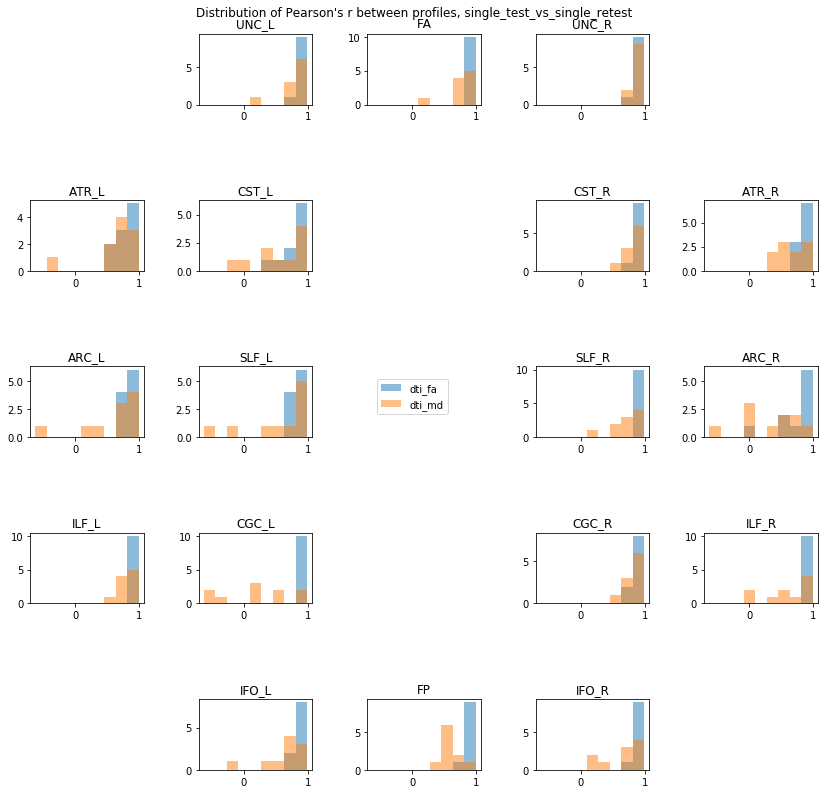

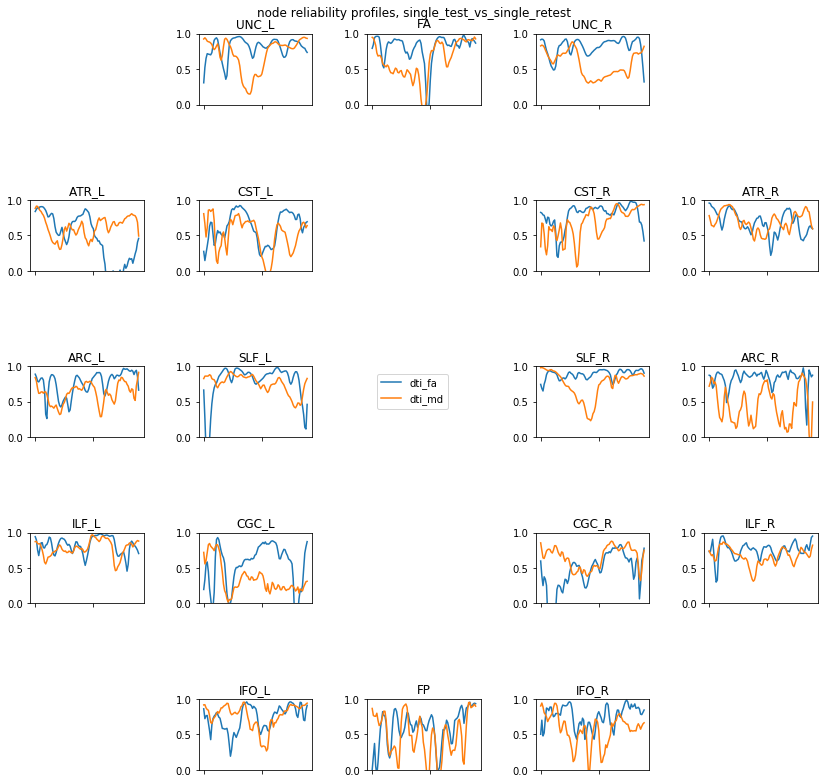

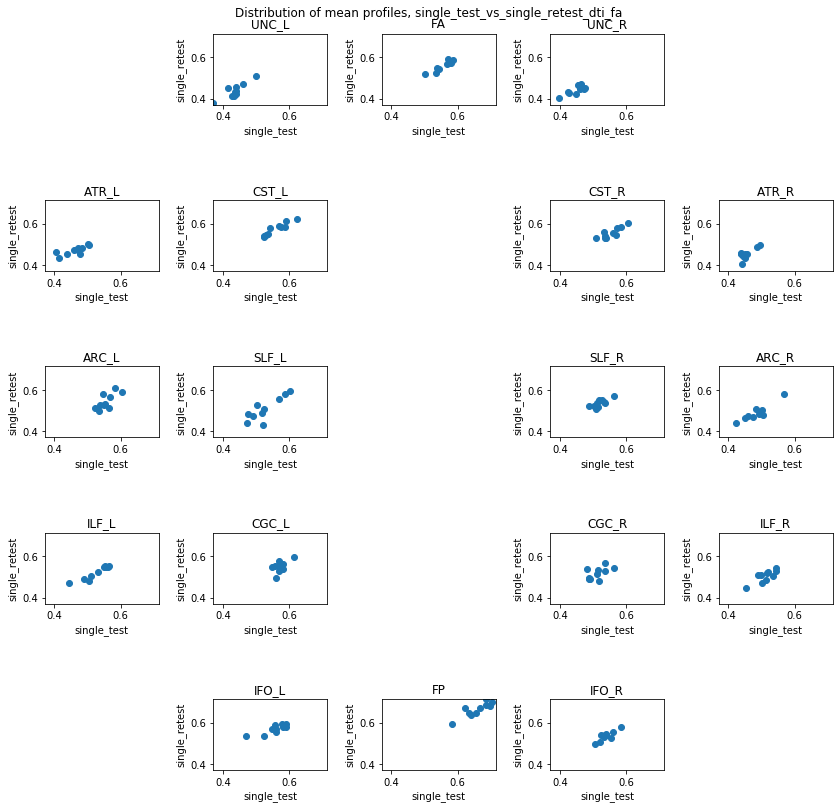

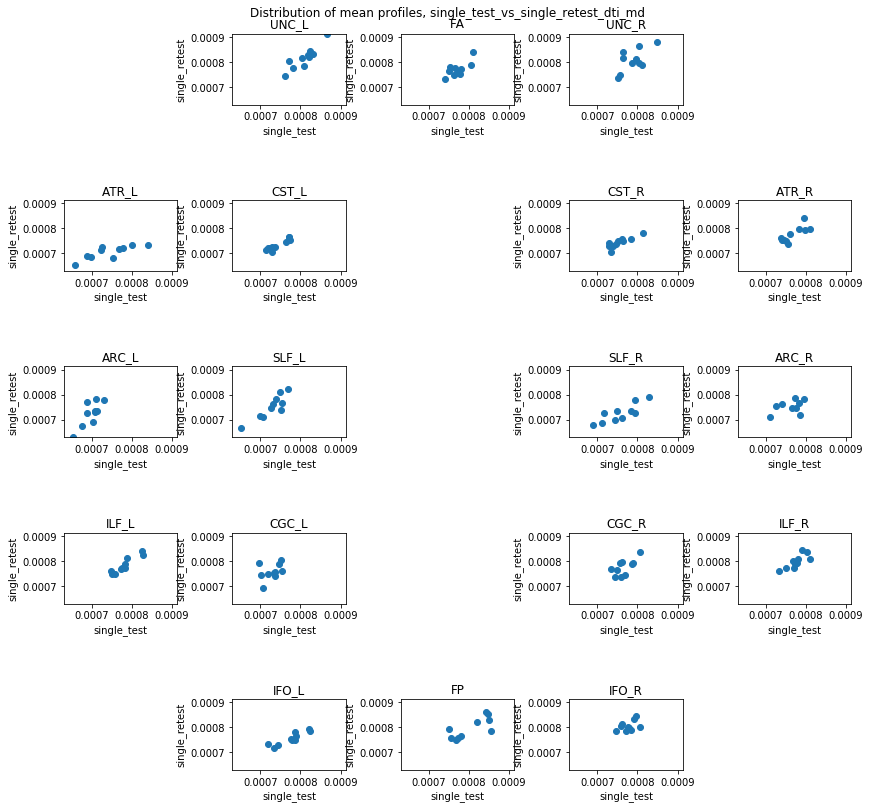

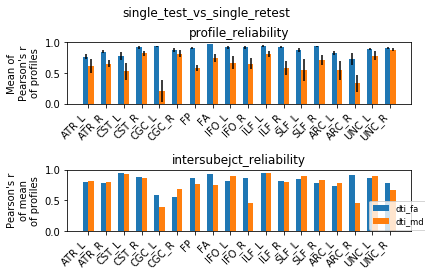

In [9]:
single_comparisons.reliability_plots(ylims=[0.0, 1.0], show_plots=True)
#multi_comparisons.reliability_plots(ylims=[0.0, 1.0], scalars=["dki_fa", "dki_md"], show_plots=True)